In [5]:
import pickle
import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sys
sys.path.append('/Users/akuan/repos/ppc_project_analysis/tracing_analysis')
import ppc_analysis_functions.figure_plotting as figs

workingDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/analysis_dataframes/'
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/figures_working/rev1/'

In [6]:
# 220513 single-trial activity for to possibly look at effect of inhibition?
with open(workingDir + 'MN_DF_PPC_11sess.pkl' , 'rb') as f:  
    MN_DF_all = pickle.load(f)
with open(workingDir + 'MN_DF_PPC.pkl' , 'rb') as f:  
    MN_DF_PPC = pickle.load(f)


mySessions = ['LD187_141216','LD187_141215','LD187_141214','LD187_141213','LD187_141212','LD187_141211','LD187_141210','LD187_141209','LD187_141208','LD187_141207','LD187_141206']
my_DF_out = MN_DF_PPC[['matched_cell_ID','skeleton_id','type','select_idx_MI','Ca_trial_mean_bR','Ca_trial_mean_wL','sessions_ROI','choiceMI_max_idx']]

# Load metrics from neuron dataframe
skel_ids = MN_DF_all.skeleton_id.values
pref_dir = MN_DF_all.select_idx_MI.values > 0

# Load sessions data and assemble concatenated trial data
trialData = {} # initialize dict for output metrics
for skel_id in skel_ids:
    trialData[skel_id] = {}
    trialData[skel_id]['nAct_norm_t'] = np.empty((63,0))
    trialData[skel_id]['nAct'] = np.array([])
    trialData[skel_id]['cueType'] = np.array([])
    trialData[skel_id]['cueDir'] = np.array([])
    trialData[skel_id]['choice'] = np.array([])
    trialData[skel_id]['isCorrect'] = np.array([])

nAct_norm_all= np.empty((len(skel_ids), len(mySessions)))
nAct_norm_all[:] = np.nan

for s_idx,session in enumerate(mySessions): 
    print(session)
    mat_path = "/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/2P_data/trialAlignedData/%s.mat" % session
    with h5py.File(mat_path, 'r') as f: # Load relevant trial data from .mat files
        CaData = np.array(f['trialAlignedData']['CaData'])
        cueType =  np.transpose(np.array(f['trialAlignedData']['cueType']))[0]
        cueDir = np.transpose(np.array(f['trialAlignedData']['cueDir']))[0]
        choice = np.transpose(np.array(f['trialAlignedData']['choice']))[0]
        isCorrect = np.transpose(np.array(f['trialAlignedData']['isCorrect']))[0]

    for n_idx,rois in enumerate(MN_DF_all.sessions_ROI.values): # Loop over each neuron
        roi = rois[s_idx]
        skel_id = skel_ids[n_idx]
        if roi != -1:        
            nAct = CaData[13:,:,roi] # Exclude ITI before
            nAct_mean = np.nanmean(nAct, axis=0) # Avg over timepoints
            nAct_scale = np.nanmean(nAct_mean, axis=0) # Avg over trials for normalization
            nAct_norm = nAct_mean/nAct_scale # Rel act compared to avg act for the session 
            nAct_norm_t = nAct/nAct_scale

            trialData[skel_id]['nAct_norm_t'] = np.concatenate((trialData[skel_id]['nAct_norm_t'], nAct_norm_t), axis=1)
            trialData[skel_id]['nAct'] = np.concatenate((trialData[skel_id]['nAct'], nAct_norm)) # nAct_norm is default
            trialData[skel_id]['cueType'] = np.concatenate((trialData[skel_id]['cueType'], cueType))
            trialData[skel_id]['cueDir'] = np.concatenate((trialData[skel_id]['cueDir'], cueDir))
            trialData[skel_id]['choice'] = np.concatenate((trialData[skel_id]['choice'], choice))
            trialData[skel_id]['isCorrect'] = np.concatenate((trialData[skel_id]['isCorrect'], isCorrect))
# Checked against MATLAB results so far       

LD187_141216
LD187_141215
LD187_141214
LD187_141213
LD187_141212
LD187_141211
LD187_141210
LD187_141209
LD187_141208
LD187_141207
LD187_141206


In [5]:
trialData[skel_id]['nAct_norm_t'].shape

(63, 746)

In [12]:
# Calculate activity for different types of trials
n_shuf = 1000
for n_idx,skel_id in enumerate(MN_DF_all.skeleton_id.values): 
    nAct_norm_t = trialData[skel_id]['nAct_norm_t']
    nAct = trialData[skel_id]['nAct']
    pref = pref_dir[n_idx]
    cueType = trialData[skel_id]['cueType']
    cueDir = trialData[skel_id]['cueDir']
    isCorrect = trialData[skel_id]['isCorrect']
    isError = np.logical_not(isCorrect)

    orig =  np.logical_or(cueType == 2, cueType == 3) # orig 2 cues
    og_correct =  np.logical_and(orig, isCorrect) # orig 2 cues
    og_error =  np.logical_and(orig, isError)
    og_pref =  np.logical_and(orig, cueDir == pref) # pref dir determined by select_idx
    og_pref_correct =  np.logical_and(og_pref, isCorrect) 
    og_pref_error =  np.logical_and(og_pref, isError) 
    og_nonpref =  np.logical_and(orig, np.logical_not(cueDir == pref))
    og_nonpref_correct =  np.logical_and(og_nonpref, isCorrect) 
    og_nonpref_error =  np.logical_and(og_nonpref, isError) 

    # Save average time-courses for plotting 
    trialData[skel_id]['pref_correct_act'] = np.nanmean(nAct_norm_t[:,og_pref_correct], axis=1) #/ np.nanmean(nAct[og_pref])
    trialData[skel_id]['pref_error_act'] = np.nanmean(nAct_norm_t[:,og_pref_error], axis=1) #/ np.nanmean(nAct[og_pref])
    trialData[skel_id]['nonpref_correct_act'] = np.nanmean(nAct_norm_t[:,og_nonpref_correct], axis=1) #/ np.nanmean(nAct[og_nonpref])
    trialData[skel_id]['nonpref_error_act'] = np.nanmean(nAct_norm_t[:,og_nonpref_error], axis=1) #/ np.nanmean(nAct[og_nonpref])

    # Count number of each type of trial (for reference)
    trialData[skel_id]['n_trials_pref_correct'] = sum(og_pref_correct)
    trialData[skel_id]['n_trials_pref_error'] = sum(og_pref_error)
    trialData[skel_id]['n_trials_nonpref_correct'] = sum(og_nonpref_correct)
    trialData[skel_id]['n_trials_nonpref_error'] = sum(og_nonpref_error)

    if sum(og_pref_error) > 3 and sum(og_nonpref_error) > 3: # only include neurons with >3 error trials
        err_diff_pref = (np.nanmean(nAct[og_pref_error])-np.nanmean(nAct[og_pref_correct]))/np.nanmean(nAct[og_pref])
        err_diff_nonpref = (np.nanmean(nAct[og_nonpref_error])-np.nanmean(nAct[og_nonpref_correct]))/np.nanmean(nAct[og_nonpref])
        pref_diff_err = (np.nanmean(nAct[og_nonpref_error])-np.nanmean(nAct[og_pref_error]))/np.nanmean(nAct[og_error])
        pref_diff_corr = (np.nanmean(nAct[og_pref_correct])-np.nanmean(nAct[og_nonpref_correct]))/np.nanmean(nAct[og_correct])

        err_diff_combined = err_diff_nonpref - err_diff_pref
        
        # Permutation test:
        err_diff_pref_shuf = np.empty((n_shuf))
        err_diff_nonpref_shuf = np.empty((n_shuf))
        err_diff_combined_shuf = np.empty((n_shuf))
        for ix in range(n_shuf):
            nAct_shuf = np.random.permutation(nAct) # Shuffle activity across trials
            err_diff_pref_shuf[ix] = (np.nanmean(nAct_shuf[og_pref_error])-np.nanmean(nAct_shuf[og_pref_correct]))/np.nanmean(nAct_shuf[og_pref])
            err_diff_nonpref_shuf[ix] = (np.nanmean(nAct_shuf[og_nonpref_error])-np.nanmean(nAct_shuf[og_nonpref_correct]))/np.nanmean(nAct_shuf[og_nonpref])
            err_diff_combined_shuf[ix] = err_diff_nonpref_shuf[ix] - err_diff_pref_shuf[ix]
            
        trialData[skel_id]['err_diff_pref'] = err_diff_pref
        trialData[skel_id]['err_diff_nonpref'] = err_diff_nonpref
        trialData[skel_id]['err_diff_pref_shuf'] = err_diff_pref_shuf
        trialData[skel_id]['err_diff_nonpref_shuf'] = err_diff_nonpref_shuf
        trialData[skel_id]['err_diff_pref_prc'] = stats.percentileofscore(err_diff_pref_shuf, err_diff_pref)
        trialData[skel_id]['err_diff_nonpref_prc'] = stats.percentileofscore(err_diff_nonpref_shuf, err_diff_nonpref)

        trialData[skel_id]['pref_diff_err'] = pref_diff_err
        trialData[skel_id]['pref_diff_corr'] = pref_diff_corr

        trialData[skel_id]['err_diff_combined'] = err_diff_combined
        trialData[skel_id]['err_diff_combined_shuf'] = err_diff_combined_shuf
        trialData[skel_id]['err_diff_combined_prc'] = stats.percentileofscore(err_diff_combined_shuf, err_diff_combined)
    else:
        trialData[skel_id].update({'err_diff_pref':np.nan,'err_diff_nonpref':np.nan,
        'err_diff_pref_prc':np.nan, 'err_diff_nonpref_prc':np.nan, 'pref_diff_err':np.nan,
        'pref_diff_corr':np.nan, 'err_diff_combined':np.nan, 'err_diff_combined_shuf':np.nan,
        'err_diff_combined_prc':np.nan})

MN_DF_all['n_trials_pref_correct'] = [trialData[i]['n_trials_pref_correct'] for i in skel_ids] 
MN_DF_all['n_trials_pref_error'] = [trialData[i]['n_trials_pref_error'] for i in skel_ids] 
MN_DF_all['n_trials_nonpref_correct'] = [trialData[i]['n_trials_nonpref_correct'] for i in skel_ids] 
MN_DF_all['n_trials_nonpref_error'] = [trialData[i]['n_trials_nonpref_error'] for i in skel_ids] 

MN_DF_all['pref_correct_act'] = [trialData[i]['pref_correct_act'] for i in skel_ids] 
MN_DF_all['pref_error_act'] = [trialData[i]['pref_error_act'] for i in skel_ids] 
MN_DF_all['nonpref_correct_act'] = [trialData[i]['nonpref_correct_act'] for i in skel_ids] 
MN_DF_all['nonpref_error_act'] = [trialData[i]['nonpref_error_act'] for i in skel_ids] 

MN_DF_all['err_diff_pref'] = [trialData[i]['err_diff_pref'] for i in skel_ids]
MN_DF_all['err_diff_nonpref'] = [trialData[i]['err_diff_nonpref'] for i in skel_ids]
MN_DF_all['err_diff_pref_prc'] = [trialData[i]['err_diff_pref_prc'] for i in skel_ids]
MN_DF_all['err_diff_nonpref_prc'] = [trialData[i]['err_diff_nonpref_prc'] for i in skel_ids]

MN_DF_all['pref_diff_err'] = [trialData[i]['pref_diff_err'] for i in skel_ids]
MN_DF_all['pref_diff_corr'] = [trialData[i]['pref_diff_corr'] for i in skel_ids]

MN_DF_all['err_diff_combined'] = [trialData[i]['err_diff_combined'] for i in skel_ids]
MN_DF_all['err_diff_combined_shuf'] = [trialData[i]['err_diff_combined_shuf'] for i in skel_ids]
MN_DF_all['err_diff_combined_prc'] = [trialData[i]['err_diff_combined_prc'] for i in skel_ids]

26266   -0.37772
Name: select_idx_MI, dtype: float64
143896    0.259254
Name: select_idx_MI, dtype: float64


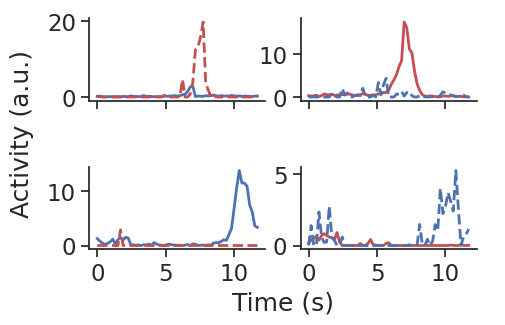

In [75]:
# Plot example neurons activity and MI
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(5, 3),ncols=2, nrows=2, sharey=False, sharex=True)
plt.subplots_adjust(hspace = .8, wspace=0.2)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (s)")
plt.ylabel("Activity (a.u.)")

my_DF = MN_DF_all

my_I_Cell = my_DF[my_DF.skeleton_id == 26266]
my_E_Cell = my_DF[my_DF.skeleton_id == 143896] #143896 179145
print(my_I_Cell.select_idx_MI)
print(my_E_Cell.select_idx_MI)

plt.style.use('default')
plt.rcParams['font.size'] = '10'
#fig, ax = plt.subplots(1,1)
#plt.subplots_adjust(wspace=0.05)
t = np.linspace(0,62,num=63)/5.3
t_cue = np.array([0,25])/5.3
t_delay = np.array([26,50])/5.3
t_turn = np.array([51,62])/5.3

# I cell is left selective
ax3.plot(t,my_I_Cell['pref_correct_act'].values[0],'b-', linewidth=2, alpha=1)
ax3.plot(t,my_I_Cell['pref_error_act'].values[0],'r--',linewidth=2, alpha=1)
ax4.plot(t,my_I_Cell['nonpref_correct_act'].values[0],'r-', linewidth=2, alpha=1)
ax4.plot(t,my_I_Cell['nonpref_error_act'].values[0],'b--',linewidth=2, alpha=1)
#ax4.set_ylim(ax3.get_ylim())
#ax4.set_yticklabels([])

# E cell is right selective
ax1.plot(t,my_E_Cell['nonpref_correct_act'].values[0],'b-', linewidth=2, alpha=1)
ax1.plot(t,my_E_Cell['nonpref_error_act'].values[0],'r--',linewidth=2, alpha=1)
ax2.plot(t,my_E_Cell['pref_correct_act'].values[0],'r-', linewidth=2, alpha=1)
ax2.plot(t,my_E_Cell['pref_error_act'].values[0],'b--',linewidth=2, alpha=1)
#ax2.set_ylim(ax1.get_ylim())
#ax2.set_yticklabels([])
sns.despine()
plt.savefig(figsDir+'ex_err_diff.pdf',bbox_inches='tight')

<AxesSubplot:xlabel='n_trials_nonpref_error', ylabel='count'>

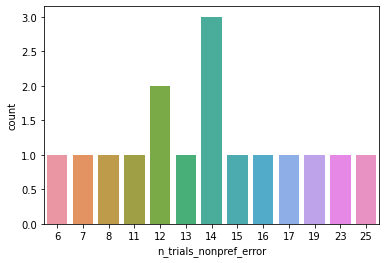

In [9]:
sns.countplot(data = MN_DF_all[MN_DF_all.type == 'non pyramidal'], x = 'n_trials_nonpref_error')

In [59]:
my_E_Cell[['err_diff_pref', 'err_diff_nonpref', 'err_diff_combined']]
#print(np.sum(my_E_Cell.pref_correct_act.values[0]))
#print(np.sum(my_E_Cell.pref_error_act.values[0]))


,err_diff_pref,err_diff_nonpref,err_diff_combined
143896,-0.73285,2.695595,3.428444


In [167]:
#plt.plot(trialData[MN_DF_all.skeleton_id.values[144]]['nAct'])
MN_DF_all.err_diff_nonpref_prc.values

print(sum(MN_DF_all.err_diff_pref_prc.values>97.5))
print(sum(MN_DF_all.err_diff_pref_prc.values<2.5))
print(sum(MN_DF_all.err_diff_nonpref_prc.values>97.5))
print(sum(MN_DF_all.err_diff_nonpref_prc.values<2.5))


print(sum(MN_DF_all.err_diff_nonpref_prc.values>99.5))

5
19
41
4
30


Excitatory: n = 105, Inh: n = 15
Exc Pref: 0.812464 +- [-0.903280,0.732883]
Inh Pref: 0.968693 +- [-0.741106,0.349444]
WilcoxonResult(statistic=1198.0, pvalue=8.888128992980365e-12)
WilcoxonResult(statistic=12.0, pvalue=0.03863525390625)
MannwhitneyuResult(statistic=728.0, pvalue=0.6396583299166944)


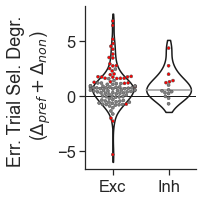

In [13]:
# Plot err diff plots
sns.set(rc={'figure.figsize':(2,3)}, font_scale=1.5, style='ticks')
plt.subplots_adjust(hspace = .4, wspace=0.4)
pal = {'pyramidal':'white','non pyramidal':'white'}
sig_pal = {True:'red',False:'grey'}

MN_DF_all['err_diff_combined_sig'] = np.logical_or(MN_DF_all.err_diff_combined_prc > 97.5,MN_DF_all.err_diff_combined_prc < 2.5)
#MN_DF_all['err_diff_combined_sig'] = MN_DF_all.err_diff_combined_prc > 95

g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'],palette = pal, cut=1, saturation =0.5) 
#kwargs={"marker":'^'}
sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'], hue='err_diff_combined_sig', linewidth=.5,palette=sig_pal,color='k',s=3)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
#g.set_ylim([-1,5])
g.set_ylabel('Err. Trial Sel. Degr. \n ($Δ_{pref} + Δ_{non}$)')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])


MN_DF_E = MN_DF_all[MN_DF_all.type=='pyramidal'].dropna(subset=['err_diff_combined'])
MN_DF_I = MN_DF_all[MN_DF_all.type=='non pyramidal'].dropna(subset=['err_diff_combined'])
print('Excitatory: n = %i, Inh: n = %i' % (len(MN_DF_E), len(MN_DF_I)))
(E_pref_med,I_pref_med)  = (np.median(MN_DF_E.err_diff_combined),np.median(MN_DF_I.err_diff_combined))
(E_pref_avg,I_pref_avg)  = (np.mean(MN_DF_E.err_diff_combined),np.mean(MN_DF_I.err_diff_combined))

print('Exc Pref: %f +- [%f,%f]' % (E_pref_avg, np.percentile(MN_DF_E.err_diff_combined,25)-E_pref_avg,np.percentile(MN_DF_E.err_diff_combined,75)-E_pref_avg))
print('Inh Pref: %f +- [%f,%f]' % (I_pref_avg, np.percentile(MN_DF_I.err_diff_combined,25)-I_pref_avg,np.percentile(MN_DF_I.err_diff_combined,75)-I_pref_avg))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_combined.values))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_combined.values))
print(stats.mannwhitneyu(MN_DF_E.err_diff_combined.values, MN_DF_I.err_diff_combined.values))

sns.despine()
#plt.savefig(figsDir+'err_diffs_combined.pdf',bbox_inches='tight')

Data corr = 0.470
Quick est p = 0.000
n = 120, shuf p = 0.000


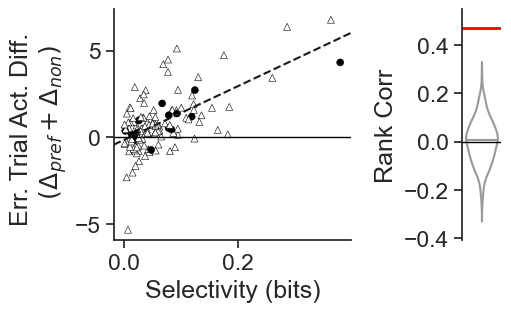

In [74]:
sns.set(rc={'figure.figsize':(5,3)}, font_scale=1.5, style='ticks')
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.4, 0.4]})
plt.subplots_adjust(hspace = .4, wspace=0.8)

#figs.scatter(E2I_cn_DF, x='pair_select_idx', y='syn_den', errs = 'pair_select_idx_stdmean', sig_test='spearman',hue='pair_selectivity',  palette = {'Opp':'#ba48cf',#'Non':'#A8ADA9','Same':'#2CB899'}, s=50, ax=ax0)

n_shuf = 500
order = ['pyramidal','non pyramidal']
MN_DF_all = MN_DF_all[MN_DF_all.type.isin(order)]
pal = {'pyramidal':'white','non pyramidal':'black'}

markers = {'pyramidal':'^','non pyramidal':'o'}
y = 'err_diff_pref'
#y = 'err_diff_nonpref'
y = 'err_diff_combined'

MN_DF_all['abs_select_idx'] = np.abs(MN_DF_all.select_idx_MI.values)
(c,p) = figs.scatter(MN_DF_all, x='abs_select_idx', y=y, color='k',sig_test='spearman',s=25, ax=ax0, style='type', markers = markers, hue='type', palette=pal)
ax0.set_xlabel('Selectivity (bits)') 
#ax0.set_ylabel('Δ Activity (err. - corr.)')
ax0.set_ylabel('Err. Trial Act. Diff. \n $(Δ_{pref} + Δ_{non})$')
if y == 'err_diff_pref':
    ax0.set_title('pref.')
elif y == 'err_diff_nonpref':
    ax0.set_title('non-pref.')
ax0.axhline(y=0, color='black', linestyle='-', linewidth=1)
#ax0.set_yscale('log')
ax0.get_legend().remove()
#ax0.set_ylim([-2,2])
import importlib
importlib.reload(figs)
(shuf_df, scores) = figs.calc_shuffle_comparisons_new(MN_DF_all, x='abs_select_idx',y=y, n_shuf=n_shuf)
figs.my_violinplot(data = shuf_df[shuf_df['shuf'].isin(['shuf'])], x='shuf', y='corrs', ci='sd', order = ['shuf'], 
     palette = ['white'], cut=2, scale='width', ax=ax1)
ax1.axhline(y=c, color='red', linestyle='-', linewidth=2)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)

ax1.set_ylabel('Rank Corr')
ax1.set_xlabel('')
ax1.set_xticks([])

sns.despine()
ax1.spines['bottom'].set_visible(False)
plt.savefig(figsDir+'select_idx_VS_'+y+'.pdf',bbox_inches='tight')

100.0
100.0


<AxesSubplot:ylabel='Count'>

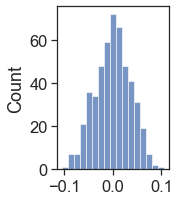

In [153]:
err_diff_combined_E_shuf = [np.mean([val[idx] for val in MN_DF_E['err_diff_combined_shuf']]) for idx in range(n_shuf)]
err_diff_combined_I_shuf = [np.mean([val[idx] for val in MN_DF_I['err_diff_combined_shuf']]) for idx in range(n_shuf)]

print(stats.percentileofscore(err_diff_combined_I_shuf, I_pref_avg))
print(stats.percentileofscore(err_diff_combined_E_shuf, E_pref_avg))

sns.histplot(err_diff_combined_E_shuf)

Excitatory: n = 105, Inh: n = 15
Preferred
Exc Pref: -0.215271 +- [-0.443316,0.484361]
Inh Pref: -0.234120 +- [-0.281572,0.543581]
WilcoxonResult(statistic=1915.0, pvalue=3.8199877306423607e-07)
WilcoxonResult(statistic=46.0, pvalue=0.274444580078125)
MannwhitneyuResult(statistic=933.0, pvalue=0.3153808008199761)
Non Preferred
Exc Nonpref: 0.350295 +- [-0.596999,0.531304]
Inh Nonpref: 0.432714 +- [-0.175659,0.129013]
WilcoxonResult(statistic=1343.0, pvalue=9.774024806509478e-11)
WilcoxonResult(statistic=14.0, pvalue=0.0506591796875)
MannwhitneyuResult(statistic=947.0, pvalue=0.3481460108685379)


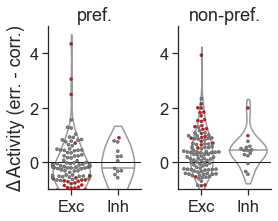

In [64]:
# Plot err diff plots (old metrics with pref/non-pref
sns.set(rc={'figure.figsize':(4,3)}, font_scale=1.5, style='ticks')
plt.subplots_adjust(hspace = .4, wspace=0.4)
pal = {'pyramidal':'white','non pyramidal':'white'}
sig_pal = {True:'red',False:'grey'}
MN_DF_all['err_diff_pref_sig'] = np.logical_or(MN_DF_all.err_diff_pref_prc > 97.5,MN_DF_all.err_diff_pref_prc < 2.5)
MN_DF_all['err_diff_nonpref_sig'] = np.logical_or(MN_DF_all.err_diff_nonpref_prc > 97.5,MN_DF_all.err_diff_nonpref_prc < 2.5)

plt.subplot(1,2,1)
g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_pref', order = ['pyramidal','non pyramidal'],palette = pal, cut=1, saturation =0.5) 
#kwargs={"marker":'^'}
sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_pref', order = ['pyramidal','non pyramidal'], hue='err_diff_pref_sig', linewidth=.5,palette=sig_pal,color='k',s=3)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
g.set_ylim([-1,5])
g.set_ylabel('Δ Activity (err. - corr.)')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])
g.set_title('pref.')

plt.subplot(1,2,2)
g=figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_nonpref', order = ['pyramidal','non pyramidal'], palette = pal, cut=1, saturation = 0.5)

sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_nonpref', order = ['pyramidal','non pyramidal'], hue='err_diff_nonpref_sig', linewidth=.5,palette=sig_pal,color='k',s=3)
g.axhline(y=0,color='k', linewidth=1)
g.get_legend().remove()
g.set_ylim([-1,5])
g.set_ylabel('')
g.set_ylabel('')
g.set_xlabel('')
g.set_xticklabels(['Exc','Inh'])
g.set_title('non-pref.')
sns.despine()

MN_DF_E = MN_DF_all[MN_DF_all.type=='pyramidal'].dropna(subset=['err_diff_pref','err_diff_nonpref'])
MN_DF_I = MN_DF_all[MN_DF_all.type=='non pyramidal'].dropna(subset=['err_diff_pref','err_diff_nonpref'])
print('Excitatory: n = %i, Inh: n = %i' % (len(MN_DF_E), len(MN_DF_I)))
print('Preferred')
(E_pref_med,I_pref_med)  = (np.median(MN_DF_E.err_diff_pref),np.median(MN_DF_I.err_diff_pref))
print('Exc Pref: %f +- [%f,%f]' % (E_pref_med, np.percentile(MN_DF_E.err_diff_pref,25)-E_pref_med,np.percentile(MN_DF_E.err_diff_pref,75)-E_pref_med))
print('Inh Pref: %f +- [%f,%f]' % (I_pref_med, np.percentile(MN_DF_I.err_diff_pref,25)-I_pref_med,np.percentile(MN_DF_I.err_diff_pref,75)-I_pref_med))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_pref.values))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_pref.values))

print(stats.mannwhitneyu(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_pref.values, 
    MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_pref.values))
print('Non Preferred')
(E_nonpref_med,I_nonpref_med)  = (np.median(MN_DF_E.err_diff_nonpref),np.median(MN_DF_I.err_diff_nonpref))
print('Exc Nonpref: %f +- [%f,%f]' % (E_nonpref_med, np.percentile(MN_DF_E.err_diff_nonpref,25)-E_nonpref_med,np.percentile(MN_DF_E.err_diff_nonpref,75)-E_nonpref_med))
print('Inh Nonpref: %f +- [%f,%f]' % (I_nonpref_med, np.percentile(MN_DF_I.err_diff_nonpref,25)-I_nonpref_med,np.percentile(MN_DF_I.err_diff_nonpref,75)-I_nonpref_med))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_nonpref.values))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_nonpref.values))
print(stats.mannwhitneyu(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_nonpref.values, 
    MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_nonpref.values))

#plt.savefig(figsDir+'err_diffs.pdf',bbox_inches='tight')

WilcoxonResult(statistic=1258.0, pvalue=2.4328298265209066e-11)
WilcoxonResult(statistic=13.0, pvalue=0.0443115234375)
MannwhitneyuResult(statistic=908.0, pvalue=0.26045319934429406)


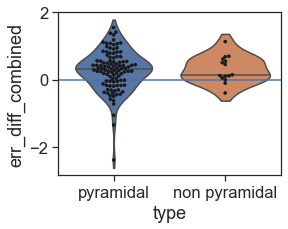

In [74]:

g=sns.swarmplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'], linewidth=.5,color='k',s=3)
figs.my_violinplot(data = MN_DF_all, x='type',y='err_diff_combined', order = ['pyramidal','non pyramidal'], cut=1)
MN_DF_all.err_diff_combined.values
g.axhline(y=0)
#g.axhline(y=1)
#g.axhline(y=-1)
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_combined.values))
print(stats.wilcoxon(MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_combined.values))
print(stats.mannwhitneyu(MN_DF_all[MN_DF_all.type=='pyramidal'].err_diff_combined.values, 
    MN_DF_all[MN_DF_all.type=='non pyramidal'].err_diff_combined.values))

<AxesSubplot:ylabel='Count'>

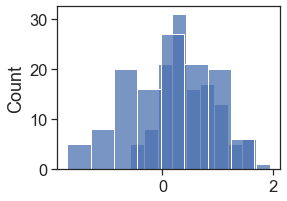

In [99]:
sns.histplot(MN_DF_all.pref_diff_corr.values)
sns.histplot(MN_DF_all.pref_diff_err.values)

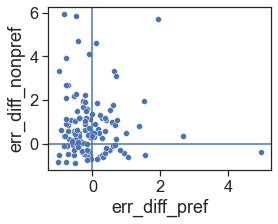

In [100]:
g=sns.scatterplot(data = MN_DF_all, x = 'err_diff_pref', y='err_diff_nonpref')
g.axhline(y=0)
g.axvline(x=0)

-0.08375708656428078

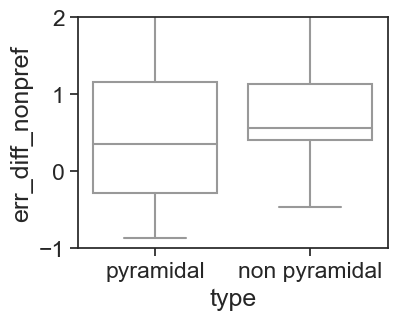

In [111]:
sns.boxplot(data = MN_DF_all.dropna(subset=['err_diff_pref','err_diff_nonpref']), x='type',y='err_diff_nonpref', order = ['pyramidal','non pyramidal'], palette = pal, whis = np.inf)
plt.ylim([-1,2])
np.mean(MN_DF_I.err_diff_pref)

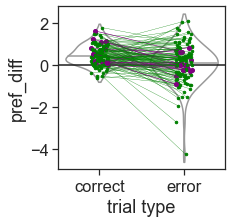

In [16]:
sns.set(rc={'figure.figsize':(3,3)}, font_scale=1.5, style='ticks')
pref_diff_corr_DF = pd.DataFrame({'pref_diff':MN_DF_all.pref_diff_corr.values,'type': MN_DF_all.type.values,'trial type':'correct','select_idx':MN_DF_all.select_idx_MI.values})
pref_diff_err_DF = pd.DataFrame({'pref_diff':MN_DF_all.pref_diff_err.values,'type': MN_DF_all.type.values,
'trial type':'error','select_idx':MN_DF_all.select_idx_MI.values})
pref_diff_DF = pd.concat([pref_diff_corr_DF, pref_diff_err_DF])
pref_diff_DF = pref_diff_DF[pref_diff_DF.type.isin(['pyramidal', 'non pyramidal'])]
g=figs.my_violinplot(data=pref_diff_DF, x='trial type',y='pref_diff', color='w', scale='width', cut = 1)
g.axhline(y=0, color='k', linestyle='-')
for index, row in MN_DF_all.iterrows():
    if row.type == 'non pyramidal':
        color = 'purple'
        size = 8
        thick = 0.6
    else:
        color = 'green'
        size = 5
        thick = 0.3
    plt.plot([-0.1+np.random.rand()/5,0.9+np.random.rand()/5], [row.pref_diff_corr, row.pref_diff_err], '.-',  markersize= size, color = color, linewidth = thick)
#plt.savefig(figsDir+'pref_diff.pdf',bbox_inches='tight')

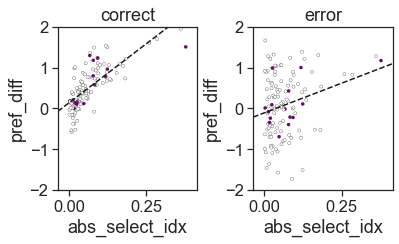

In [30]:
pal = {'pyramidal':'w','non pyramidal':'purple'}
markers = {'pyramidal':'^','non pyramidal':'o'}

sns.set(rc={'figure.figsize':(6,3)}, font_scale=1.5, style='ticks')
plt.subplots_adjust(hspace = .4, wspace=0.4)
pref_diff_corr_DF['abs_select_idx'] = np.abs(pref_diff_corr_DF.select_idx.values)
plt.subplot(1,2,1)
figs.scatter(pref_diff_corr_DF, x='abs_select_idx',y='pref_diff', hue='type', palette=pal)
plt.title('correct')
plt.ylim([-2,2])

plt.subplot(1,2,2)
pref_diff_err_DF['abs_select_idx'] = np.abs(pref_diff_err_DF.select_idx.values)
figs.scatter(pref_diff_err_DF, x='abs_select_idx',y='pref_diff', hue='type', palette=pal)
plt.title('error')
plt.ylim([-2,2])
plt.savefig(figsDir+'pref_diff_err_correct.pdf',bbox_inches='tight')

(0.317453663695812, 0.00034651264491919394)

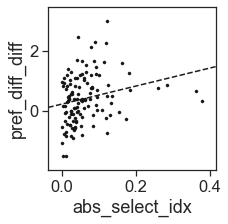

In [74]:
# Do neurons that switch selectivity have higher select_idx?
MN_DF_all['pref_diff_diff'] = MN_DF_all.pref_diff_corr.values - MN_DF_all.pref_diff_err.values
MN_DF_all['abs_select_idx'] = np.abs(MN_DF_all.select_idx_MI.values)
MN_DF_all['abs_pref_diff_err'] = np.abs(MN_DF_all.pref_diff_err.values)
figs.scatter(MN_DF_all, x='abs_select_idx',y='pref_diff_diff')

In [209]:
MN_DF_all['abs_select_idx'] = np.abs(MN_DF_all.select_idx_MI.values)
MN_DF_all[MN_DF_all.type=='non pyramidal'][['skeleton_id','err_diff_nonpref','err_diff_pref','select_idx_MI']].sort_values(by='select_idx_MI')
MN_DF_all[MN_DF_all.type=='pyramidal'][['skeleton_id','err_diff_nonpref','err_diff_pref','select_idx_MI','abs_select_idx']].sort_values(by='abs_select_idx',ascending=False)

,skeleton_id,err_diff_nonpref,err_diff_pref,select_idx_MI,abs_select_idx
171009,171009.0,5.933441,-0.846017,0.361524,0.361524
175650,175650.0,NaN,NaN,0.300913,0.300913
153600,153600.0,5.881435,-0.489454,0.285146,0.285146
143896,143896.0,2.695595,-0.732850,0.259254,0.259254
58,58.0,NaN,NaN,0.227173,0.227173
143622,143622.0,NaN,NaN,0.206229,0.206229
144188,144188.0,1.105265,-0.645401,0.184199,0.184199
190204,190204.0,0.005253,-0.160434,0.181674,0.181674
143672,143672.0,3.945417,-0.789712,-0.174871,0.174871
4240,4240.0,-0.038793,-0.459099,0.164127,0.164127


(-0.3571428571428571, 0.19127476343157904)

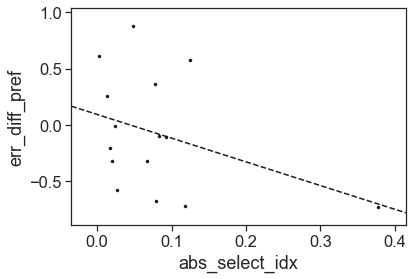

In [116]:
MN_DF_all['abs_select_idx'] = np.abs(MN_DF_all.select_idx_MI.values)
figs.scatter(MN_DF_all[MN_DF_all.type=='non pyramidal'], x='abs_select_idx',y='err_diff_pref')

Preferred
MannwhitneyuResult(statistic=960.0, pvalue=0.2607683995353438)
Non Preferred
MannwhitneyuResult(statistic=1010.0, pvalue=0.3719197013299834)


In [15]:
sum(MN_DF_all.type=='non pyramidal')

17

<AxesSubplot:xlabel='type', ylabel='err_diff_pref'>

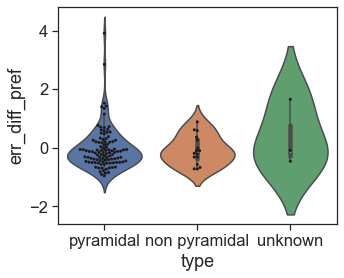

In [146]:
sns.set(rc={'figure.figsize':(5,4)}, font_scale=1.5, style='ticks')
sns.violinplot(data = MN_DF_all, y='err_diff_pref', x='type', scale='width')
sns.swarmplot(data = MN_DF_all, y='err_diff_pref', x='type', color='k', s=3)

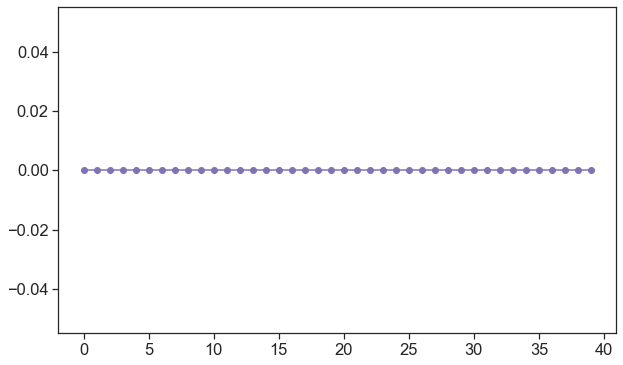

In [107]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.5, style='ticks')
#plt.plot(trialData[22901.0]['nAct'])
#plt.plot(trialData[22901.0]['isCorrect'][20:60],'bo-')
#plt.plot(trialData[22901.0]['orig'][20:60],'ro-')
#plt.plot(trialData[22901.0]['correct'][20:60],'go-')
plt.plot(trialData[22901.0]['error'][20:60],'mo-')